# Spoken Digit Experiment for Progressive Learning

This experiment will use an audio dataset named spoken_digit (https://github.com/Jakobovski/free-spoken-digit-dataset) to test the performance of progressive-learning on audio classification tasks. The dataset consists of 3,000 recordings of digit (from 0 to 9) pronounced in English, by 6 speakers: 6 (speakers) x 10 (digits) x 50 (repetitions) = 3,000 (audio files). Think MNIST for audio.


### Import necessary packages and modules

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa 
import librosa.display
import cv2
import time

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

from proglearn.progressive_learner import ProgressiveLearner
from proglearn.deciders import SimpleArgmaxAverage
from proglearn.transformers import (
    TreeClassificationTransformer,
    NeuralClassificationTransformer,
)
from proglearn.voters import TreeClassificationVoter, KNNClassificationVoter

### Load spoken_digit data and extract features
To try on the up-to-date version of spoken_digit, we download the dataset from github repo (https://github.com/Jakobovski/free-spoken-digit-dataset) to our computer.

Then we use `librosa` to load audio file, and extract the **STFT** (Short-time Fourier transform) feature. Since each audio has different durations, the STFT spectrograms vary in width. For convenience, we regularize the STFT spectrograms all to 28 by 28 images, using .resize() function from `opencv`.


In [2]:
file = os.listdir('D:/Python Exploration/free-spoken-digit-dataset/recordings')
AudioData=[]       # audio data
X_spec = []        # STFT spectrogram
X_spec_mini = []   # resized image, 28*28
Y_number = []      # label of number
Y_speaker = []     # label of speaker

Label_speaker = ['g', 'j', 'l', 'n', 't', 'y'] # first letter of speaker's name

for i in file:
    x , sr = librosa.load('D:/Python Exploration/free-spoken-digit-dataset/recordings/'+i, sr = 8000) # path of the audio files
    X = librosa.stft(x,n_fft = 128) # STFT
    Xdb = librosa.amplitude_to_db(abs(X)) # Convert an amplitude spectrogram to dB-scaled spectrogram
    Xdb_28 = cv2.resize(Xdb, (28, 28)) # resize into 28 by 28
    y_n = i[0] # number
    y_s = i[2] # first letter of speaker's name
    
    AudioData.append(x)
    X_spec.append(Xdb)
    X_spec_mini.append(Xdb_28)
    Y_number.append(y_n)
    Y_speaker.append(y_s)

# Flattening
X_all = np.array(X_spec_mini).reshape(3000,-1) # (3000, 784)
Y_all = np.array(Y_number).astype(int) # (3000,)
Y_all_speaker = np.array(Y_speaker) # (3000,), type: string

***Before running progressive learning, let's take a look at what we have now!***

In [3]:
# Play the audio
import IPython.display as ipd

num = 2222 # choose an audio to play, 0-2999
print('This is a number',Y_number[num],'spoken by speaker',Y_speaker[num].upper(),'\nLength:',AudioData[num].shape[0],'points')
ipd.Audio(AudioData[num], rate=sr)

This is a number 7 spoken by speaker L 
Length: 10399 points


Text(0.5, 1.0, '28x28')

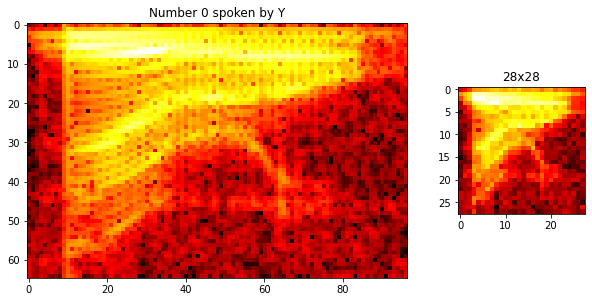

In [4]:
# Resized image
num = 250 # choose from 0 to 2999
fig, axs = plt.subplots(nrows=1, ncols=2,figsize=(10, 8),gridspec_kw={'width_ratios': [3, 1]})
axs[0].imshow(X_spec[num], cmap='hot', interpolation='nearest')
axs[0].set_title('Number '+Y_number[num]+' spoken by '+Y_speaker[num].upper())

axs[1].imshow(X_spec_mini[num], cmap='hot', interpolation= 'nearest')
axs[1].set_title('28x28')

Text(0.5, 0.98, 'Short-Time Fourier Transform Spectrograms of Number 5')

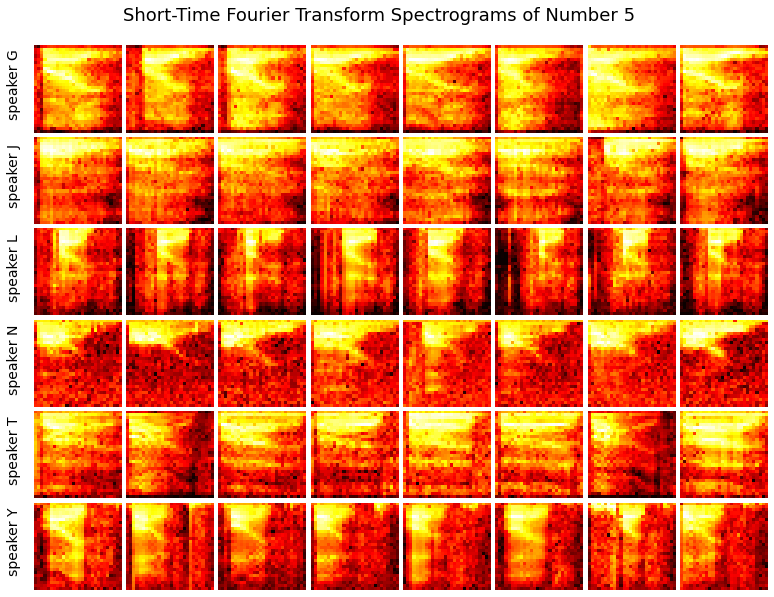

In [5]:
# Spectrograms of same number spoken by different speakers
number = 5 # choose number between 0 and 9
fig, axes = plt.subplots(nrows=6, ncols=8, sharex=True, sharey=True, figsize=(12, 9))

for j,speaker in enumerate(Label_speaker):
    opt = np.where((Y_all_speaker == speaker)&(Y_all == number))[0]
    ch = np.random.choice(opt,8,replace=False) #randomly choose 8 different samples for plotting
    #print(speaker)########these two lines were to check the index of chosen spectrograms
    #print(ch)#######remove in final version
    for i in range(8):
        axes[j,i].imshow(X_spec_mini[ch[i]], cmap='hot', interpolation='nearest')
        axes[j,i].axis('off')
        if i == 0: axes[j,i].text(-9, 12, 'speaker '+speaker.upper(), size=14, va='center', rotation='vertical')
        else: continue
                
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.05,
                    wspace=0.05)
plt.suptitle("Short-Time Fourier Transform Spectrograms of Number "+str(number), fontsize=18)

### Run progressive learning
We divide the tasks by speaker, and check whether the later learned task will transfer knowledge to the former task.

Here are the major steps:
1. Shuffle the list of speakers.
2. Pick the first speaker. Split data into train set and test set. Add the first progressive learning task and learn on the train set. Make predictions on the test set. 
3. One by one, the rest of the speakers come as train data. We add transformers using these data, and backpropagate to the first task. Make predictions on the test set in step 2, using task 1.
4. Repeat hundreds of times and average the result.

In [6]:
############################
num_iteration = 300 # repetition
num_tasks = 6
ntrees = 19
speakers = Label_speaker.copy()

iteration = []
accuracies_across_tasks = []
############################

default_transformer_class = TreeClassificationTransformer
default_transformer_kwargs = {"kwargs": {"max_depth": 30}}
default_voter_class = TreeClassificationVoter
default_voter_kwargs = {}
default_decider_class = SimpleArgmaxAverage

for i in range(num_iteration):
    print('Iteration ',i)###############
    np.random.shuffle(speakers)
    for j , speaker in enumerate(speakers):
        # initialization
        progressive_learner = ProgressiveLearner(
            default_transformer_class=default_transformer_class,
            default_transformer_kwargs=default_transformer_kwargs,
            default_voter_class=default_voter_class,
            default_voter_kwargs=default_voter_kwargs,
            default_decider_class=default_decider_class,
        )
        
        print('task 0 speaker is ',speaker)############
        
        index = np.where(Y_all_speaker==speaker)
        X = X_all[index]
        Y = Y_all[index]
        train_x_task0, test_x_task0, train_y_task0, test_y_task0 = train_test_split(X, Y, test_size=0.25)
        
        progressive_learner.add_task(
            X=train_x_task0,
            y=train_y_task0,
            task_id = 0,
            num_transformers= ntrees,
            transformer_voter_decider_split=[0.67, 0.33, 0],
            decider_kwargs={"classes": np.unique(train_y_task0)},
        )
        task_0_predictions = progressive_learner.predict(test_x_task0, task_id=0)
        accuracies_across_tasks.append(np.mean(task_0_predictions == test_y_task0))        
                
        for k , speaker in enumerate(speakers):
            if k == j: next
            else:
                index = np.where(Y_all_speaker==speaker)
                X_train = X_all[index]
                Y_train = Y_all[index]
                progressive_learner.add_transformer(
                    X=X_train,
                    y=Y_train,
                    transformer_data_proportion=1,
                    num_transformers= ntrees,
                    backward_task_ids=[0],
                )
            task_0_predictions = progressive_learner.predict(test_x_task0, task_id=0)
            accuracies_across_tasks.append(np.mean(task_0_predictions == test_y_task0))

print('All done!')

Iteration  0
task 0 speaker is  l
task 0 speaker is  n
task 0 speaker is  g
task 0 speaker is  j
task 0 speaker is  t
task 0 speaker is  y
Iteration  1
task 0 speaker is  g
task 0 speaker is  t
task 0 speaker is  n
task 0 speaker is  l
task 0 speaker is  y
task 0 speaker is  j
Iteration  2
task 0 speaker is  l
task 0 speaker is  t
task 0 speaker is  g
task 0 speaker is  j
task 0 speaker is  y
task 0 speaker is  n
Iteration  3
task 0 speaker is  l
task 0 speaker is  t
task 0 speaker is  y
task 0 speaker is  n
task 0 speaker is  j
task 0 speaker is  g
Iteration  4
task 0 speaker is  y
task 0 speaker is  l
task 0 speaker is  n
task 0 speaker is  g
task 0 speaker is  t
task 0 speaker is  j
Iteration  5
task 0 speaker is  g
task 0 speaker is  l
task 0 speaker is  j
task 0 speaker is  t
task 0 speaker is  n
task 0 speaker is  y
Iteration  6
task 0 speaker is  j
task 0 speaker is  l
task 0 speaker is  y
task 0 speaker is  t
task 0 speaker is  n
task 0 speaker is  g
Iteration  7
task 0 speaker

task 0 speaker is  l
task 0 speaker is  y
Iteration  59
task 0 speaker is  y
task 0 speaker is  g
task 0 speaker is  t
task 0 speaker is  j
task 0 speaker is  l
task 0 speaker is  n
Iteration  60
task 0 speaker is  n
task 0 speaker is  t
task 0 speaker is  g
task 0 speaker is  j
task 0 speaker is  l
task 0 speaker is  y
Iteration  61
task 0 speaker is  y
task 0 speaker is  n
task 0 speaker is  t
task 0 speaker is  g
task 0 speaker is  j
task 0 speaker is  l
Iteration  62
task 0 speaker is  y
task 0 speaker is  j
task 0 speaker is  t
task 0 speaker is  n
task 0 speaker is  g
task 0 speaker is  l
Iteration  63
task 0 speaker is  n
task 0 speaker is  t
task 0 speaker is  g
task 0 speaker is  j
task 0 speaker is  y
task 0 speaker is  l
Iteration  64
task 0 speaker is  t
task 0 speaker is  n
task 0 speaker is  j
task 0 speaker is  l
task 0 speaker is  y
task 0 speaker is  g
Iteration  65
task 0 speaker is  l
task 0 speaker is  g
task 0 speaker is  j
task 0 speaker is  t
task 0 speaker is  n

task 0 speaker is  y
task 0 speaker is  g
task 0 speaker is  l
task 0 speaker is  t
task 0 speaker is  j
Iteration  118
task 0 speaker is  j
task 0 speaker is  l
task 0 speaker is  n
task 0 speaker is  t
task 0 speaker is  g
task 0 speaker is  y
Iteration  119
task 0 speaker is  y
task 0 speaker is  l
task 0 speaker is  g
task 0 speaker is  t
task 0 speaker is  n
task 0 speaker is  j
Iteration  120
task 0 speaker is  j
task 0 speaker is  y
task 0 speaker is  g
task 0 speaker is  l
task 0 speaker is  n
task 0 speaker is  t
Iteration  121
task 0 speaker is  j
task 0 speaker is  l
task 0 speaker is  t
task 0 speaker is  y
task 0 speaker is  n
task 0 speaker is  g
Iteration  122
task 0 speaker is  n
task 0 speaker is  l
task 0 speaker is  y
task 0 speaker is  j
task 0 speaker is  g
task 0 speaker is  t
Iteration  123
task 0 speaker is  l
task 0 speaker is  y
task 0 speaker is  n
task 0 speaker is  j
task 0 speaker is  t
task 0 speaker is  g
Iteration  124
task 0 speaker is  l
task 0 speake

task 0 speaker is  j
task 0 speaker is  t
task 0 speaker is  l
task 0 speaker is  g
Iteration  176
task 0 speaker is  t
task 0 speaker is  n
task 0 speaker is  g
task 0 speaker is  j
task 0 speaker is  l
task 0 speaker is  y
Iteration  177
task 0 speaker is  j
task 0 speaker is  n
task 0 speaker is  y
task 0 speaker is  l
task 0 speaker is  t
task 0 speaker is  g
Iteration  178
task 0 speaker is  l
task 0 speaker is  t
task 0 speaker is  j
task 0 speaker is  g
task 0 speaker is  n
task 0 speaker is  y
Iteration  179
task 0 speaker is  l
task 0 speaker is  n
task 0 speaker is  t
task 0 speaker is  g
task 0 speaker is  j
task 0 speaker is  y
Iteration  180
task 0 speaker is  n
task 0 speaker is  l
task 0 speaker is  j
task 0 speaker is  t
task 0 speaker is  y
task 0 speaker is  g
Iteration  181
task 0 speaker is  t
task 0 speaker is  j
task 0 speaker is  l
task 0 speaker is  n
task 0 speaker is  g
task 0 speaker is  y
Iteration  182
task 0 speaker is  t
task 0 speaker is  l
task 0 speake

task 0 speaker is  g
task 0 speaker is  l
task 0 speaker is  j
Iteration  234
task 0 speaker is  y
task 0 speaker is  l
task 0 speaker is  g
task 0 speaker is  n
task 0 speaker is  j
task 0 speaker is  t
Iteration  235
task 0 speaker is  t
task 0 speaker is  y
task 0 speaker is  g
task 0 speaker is  n
task 0 speaker is  l
task 0 speaker is  j
Iteration  236
task 0 speaker is  l
task 0 speaker is  t
task 0 speaker is  j
task 0 speaker is  y
task 0 speaker is  g
task 0 speaker is  n
Iteration  237
task 0 speaker is  g
task 0 speaker is  t
task 0 speaker is  j
task 0 speaker is  y
task 0 speaker is  l
task 0 speaker is  n
Iteration  238
task 0 speaker is  g
task 0 speaker is  l
task 0 speaker is  j
task 0 speaker is  n
task 0 speaker is  t
task 0 speaker is  y
Iteration  239
task 0 speaker is  t
task 0 speaker is  y
task 0 speaker is  n
task 0 speaker is  g
task 0 speaker is  l
task 0 speaker is  j
Iteration  240
task 0 speaker is  g
task 0 speaker is  j
task 0 speaker is  l
task 0 speake

task 0 speaker is  n
task 0 speaker is  y
Iteration  292
task 0 speaker is  t
task 0 speaker is  y
task 0 speaker is  l
task 0 speaker is  g
task 0 speaker is  j
task 0 speaker is  n
Iteration  293
task 0 speaker is  g
task 0 speaker is  n
task 0 speaker is  l
task 0 speaker is  t
task 0 speaker is  j
task 0 speaker is  y
Iteration  294
task 0 speaker is  t
task 0 speaker is  g
task 0 speaker is  n
task 0 speaker is  j
task 0 speaker is  y
task 0 speaker is  l
Iteration  295
task 0 speaker is  l
task 0 speaker is  n
task 0 speaker is  y
task 0 speaker is  t
task 0 speaker is  g
task 0 speaker is  j
Iteration  296
task 0 speaker is  j
task 0 speaker is  g
task 0 speaker is  l
task 0 speaker is  y
task 0 speaker is  t
task 0 speaker is  n
Iteration  297
task 0 speaker is  n
task 0 speaker is  y
task 0 speaker is  l
task 0 speaker is  g
task 0 speaker is  j
task 0 speaker is  t
Iteration  298
task 0 speaker is  n
task 0 speaker is  y
task 0 speaker is  j
task 0 speaker is  t
task 0 speake

In [7]:
accuracy_all_task = np.array(accuracies_across_tasks).reshape((num_iteration,num_tasks*(num_tasks+1)))
accuracy_all_task = np.average(accuracy_all_task, axis = 0)
accuracy_all_task

array([0.87458667, 0.87458667, 0.8888    , 0.89813333, 0.90405333,
       0.9068    , 0.91005333, 0.87218667, 0.88469333, 0.88469333,
       0.89517333, 0.90082667, 0.90442667, 0.90669333, 0.876     ,
       0.88981333, 0.89896   , 0.89896   , 0.90424   , 0.90853333,
       0.91194667, 0.87106667, 0.88501333, 0.89397333, 0.90021333,
       0.90021333, 0.904     , 0.90677333, 0.87722667, 0.89136   ,
       0.90026667, 0.90549333, 0.90882667, 0.90882667, 0.91026667,
       0.87637333, 0.89066667, 0.89861333, 0.90634667, 0.90962667,
       0.91152   , 0.91152   ])

In [8]:
acc = [[]for i in range(num_tasks)]

for i in range(num_tasks):
    for j in range(num_tasks - i):
        acc[i].append(accuracy_all_task[7*i+i+1+j])
acc

[[0.8745866666666664,
  0.8887999999999998,
  0.8981333333333331,
  0.9040533333333332,
  0.9067999999999993,
  0.9100533333333323],
 [0.8846933333333333,
  0.8951733333333326,
  0.900826666666667,
  0.9044266666666658,
  0.9066933333333329],
 [0.89896, 0.9042400000000007, 0.9085333333333324, 0.9119466666666664],
 [0.9002133333333332, 0.9039999999999998, 0.9067733333333331],
 [0.9088266666666663, 0.9102666666666668],
 [0.9115200000000001]]

In [9]:
bte = [[]for i in range(num_tasks)]

for i in range(num_tasks):
    for j in range(num_tasks - i):
        err_taskt_only  = 1-accuracy_all_task[7*i]
        err_up_to_taskt = 1-accuracy_all_task[7*i+i+1]
        err_all_seen    = 1-accuracy_all_task[7*i+i+1+j]
        bte[i].append(err_up_to_taskt/err_all_seen)
bte

[[1.0,
  1.1278177458033578,
  1.231151832460733,
  1.3071150639244027,
  1.345636623748204,
  1.3943077379187532],
 [1.0,
  1.0999745611803535,
  1.1626781392847578,
  1.2064732142857038,
  1.2357816519005373],
 [1.0, 1.055137844611537, 1.1046647230320592, 1.1474863718958168],
 [1.0, 1.0394444444444437, 1.0703661327231109],
 [1.0, 1.0160475482912381],
 [1.0]]

In [10]:
fte = [[]for i in range(num_tasks)]

for i in range(num_tasks):
    err_taskt_only  = 1-accuracy_all_task[7*i]
    err_up_to_taskt = 1-accuracy_all_task[7*i+i+1]
    fte[i].append(err_taskt_only/err_up_to_taskt)
fte

[[1.0],
 [1.108464384828864],
 [1.2272367379255749],
 [1.2920897915553142],
 [1.3465925709271664],
 [1.397227245328509]]

In [11]:
te = [[]for i in range(num_tasks)]

for i in range(num_tasks):
    for j in range(num_tasks - i):
        err_taskt_only  = 1-accuracy_all_task[7*i]
        err_up_to_taskt = 1-accuracy_all_task[7*i+i+1]
        err_all_seen    = 1-accuracy_all_task[7*i+i+1+j]
        te[i].append(err_taskt_only/err_all_seen)
te

[[1.0,
  1.1278177458033578,
  1.231151832460733,
  1.3071150639244027,
  1.345636623748204,
  1.3943077379187532],
 [1.108464384828864,
  1.2192826252861804,
  1.2887873084162476,
  1.3373325892857049,
  1.3698199485567266],
 [1.2272367379255749,
  1.2949039264828845,
  1.3556851311953229,
  1.4082374318594753],
 [1.2920897915553142, 1.3430555555555506, 1.383009153318072],
 [1.3465925709271664, 1.3682020802377426],
 [1.397227245328509]]

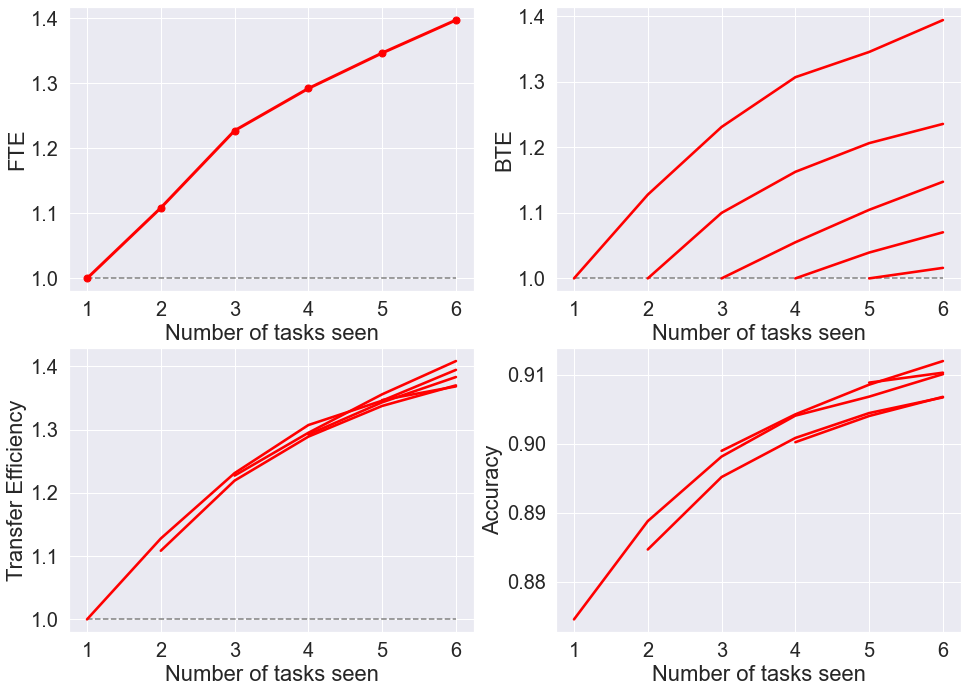

In [12]:
#%%

sns.set()

clr = ["#e41a1c", "#a65628", "#377eb8", "#4daf4a", "#984ea3", "#ff7f00", "#CCCC00"]
#c = sns.color_palette(clr, n_colors=len(clr))

fontsize=22
ticksize=20

fig, ax = plt.subplots(2,2, figsize=(16,11.5))
#fig.suptitle('ntrees = '+str(ntrees),fontsize=25)
ax[0][0].plot(np.arange(1,num_tasks+1), fte, c='red', marker='.', markersize=14, linewidth=3)
ax[0][0].hlines(1, 1,num_tasks, colors='grey', linestyles='dashed',linewidth=1.5)
ax[0][0].tick_params(labelsize=ticksize)
ax[0][0].set_xlabel('Number of tasks seen', fontsize=fontsize)
ax[0][0].set_ylabel('FTE', fontsize=fontsize)

for i in range(num_tasks):

    et = np.asarray(bte[i])

    ns = np.arange(i + 1, num_tasks + 1)
    ax[0][1].plot(ns, et, c='red', linewidth = 2.6)
    
ax[0][1].set_xlabel('Number of tasks seen', fontsize=fontsize)
ax[0][1].set_ylabel('BTE', fontsize=fontsize)
#ax[0][1].set_xticks(np.arange(1,10))
ax[0][1].tick_params(labelsize=ticksize)
ax[0][1].hlines(1, 1,num_tasks, colors='grey', linestyles='dashed',linewidth=1.5)



for i in range(num_tasks):

    et = np.asarray(te[i])

    ns = np.arange(i + 1, num_tasks + 1)
    ax[1][0].plot(ns, et, c='red', linewidth = 2.6)
    
ax[1][0].set_xlabel('Number of tasks seen', fontsize=fontsize)
ax[1][0].set_ylabel('Transfer Efficiency', fontsize=fontsize)
#ax[1][0].set_xticks(np.arange(1,10))
ax[1][0].tick_params(labelsize=ticksize)
ax[1][0].hlines(1, 1,num_tasks, colors='grey', linestyles='dashed',linewidth=1.5)

for i in range(num_tasks):
    et = np.asarray(acc[i])
    ns = np.arange(i + 1, num_tasks + 1)

    ax[1][1].plot(ns, et , c='red', linewidth = 2.6)
            
ax[1][1].set_xlabel('Number of tasks seen', fontsize=fontsize)
ax[1][1].set_ylabel('Accuracy', fontsize=fontsize)

ax[1][1].tick_params(labelsize=ticksize)